In [15]:
import keras as keras
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.losses import binary_crossentropy

from sklearn.utils import shuffle
from IPython.display import clear_output
from sklearn.neighbors import NearestNeighbors
from keras.utils import to_categorical
from keras.callbacks import Callback
import matplotlib.pyplot as plt
%matplotlib inline

 Siamese networks & one-shot learning 
The Cifar-100 dataset is similar to the Cifar-10 dataset. It also consists of 60,000 32x32 RGB images, but they are distributed over 100 classes instead of 10. Thus, each class has much fewer examples, only 500 training images and 100 testing images per class. For more info about the dataset, see https://www.cs.toronto.edu/~kriz/cifar.html.

*HINT: Import the Cifar-100 dataset directly from Keras, no need to download it from the website. Use* `label_mode="fine"`

### Task 1.1: Siamese network
**a)**
* Train a Siamese Network on the first 80 classes of (the training set of) Cifar-100, i.e. let the network predict the probability that two input images are from the same class. Use 1 as a target for pairs of images from the same class (positive pairs), and 0 for pairs of images from different classes (negative pairs). Randomly select image pairs from Cifar-100, but make sure you train on as many positive pairs as negative pairs.

* Evaluate the performance of the network on 20-way one-shot learning tasks. Do this by generating 250 random tasks and obtain the average accuracy for each evaluation round. Use the remaining 20 classes that were not used for training. The model should perform better than random guessing.

For this question you may ignore the test set of Cifar-100; it suffices to use only the training set and split this, using the first 80 classes for training and the remaining 20 classes for one-shot testing.

*HINT: First sort the data by their labels (see e.g.* `numpy.argsort()`*), then reshape the data to a shape of* `(n_classes, n_examples, width, height, depth)`*, similar to the Omniglot data in Practical 4. It is then easier to split the data by class, and to sample positive and negative images pairs for training the Siamese network.*

*NOTE: do not expect the one-shot accuracy for Cifar-100 to be similar to that accuracy for Omniglot; a lower accuracy can be expected. However, accuracy higher than random guess is certainly achievable.*

In [18]:
#load the cifar100 dataset

from keras.datasets import cifar100
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')
print('Shape of original Cifar100 data:')
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


Shape of original Cifar100 data:
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [19]:
#Splitting the data by class 

n_classes = len(np.unique(y_test, axis=None))
input_shape = x_test.shape[1:]
print('\nn_classes:', n_classes)
print('Input shape:', input_shape)

#First, sort the data by their labels
idx = np.argsort(y_train, axis=None)

#Reshape the data 
x_train = x_train[idx].reshape(n_classes, -1, *input_shape) # -1 argument:  the actual value is inferred from the length of the array and remaining dimensions, we've 500 examples per class
y_train = y_train[idx].reshape(n_classes, -1, 1)
x_train_1 = x_train[:80]
y_train_1 = y_train[:80]
x_test_1 = x_train[80:]
y_test_1 = y_train[80:]
print('\nModified:')
print(x_train_1.shape)
print(y_train_1.shape)
print(x_test_1.shape)
print(y_test_1.shape)


n_classes: 100
Input shape: (32, 32, 3)

Modified:
(80, 500, 32, 32, 3)
(80, 500, 1)
(20, 500, 32, 32, 3)
(20, 500, 1)


In [20]:
#Siamese model 

left_input = Input(input_shape)
right_input = Input(input_shape)

# build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(128, (3, 3), activation='relu', input_shape=input_shape, padding="same"))
convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.5))
convnet.add(Conv2D(128, (7, 7), activation='relu'))
convnet.add(BatchNormalization())
convnet.add(Dropout(0.5))
convnet.add(Conv2D(256, (10, 10), activation='relu', padding="same"))
# convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.5))
convnet.add(Conv2D(512, (3, 3), activation='relu', padding="same"))
# convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.5))
convnet.add(Flatten())
convnet.add(BatchNormalization())
convnet.add(Dense(256, name="neural_codes", activation="relu"))
convnet.summary()

# encode each of the two inputs into a vector with the convnet
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

# merge two encoded inputs with the L1 distance between them, and connect to prediction output layer
L1_distance = lambda x: K.abs(x[0]-x[1])
both = Lambda(L1_distance)([encoded_l, encoded_r])
prediction = Dense(1, activation='sigmoid')(both)
siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)
siamese_net.compile(loss="binary_crossentropy", optimizer="adam")
siamese_net.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 128)       802944    
_________________________________________________________________
batch_normalization_2

In [25]:
#For plotting train and test accuracies after each epoch

class PlotAccuracy(Callback):

  def on_train_begin(self, logs={}):
    self.accs = []
    self.val_accs = []
    self.fig = plt.figure()

  def on_epoch_end(self, epoch, logs={}):
    self.accs.append(logs.get('acc'))
    self.val_accs.append(logs.get('val_acc'))
    x = range(len(self.accs))

    clear_output(wait=True)
    plt.plot(x, self.accs, label="acc")
    plt.plot(x, self.val_accs, label="val_acc")
    plt.legend()
    plt.show()

# For plotting train and test losses after each epoch
class PlotLoss(Callback):

  def on_train_begin(self, logs={}):
    self.losses = []
    self.val_losses = []
    self.fig = plt.figure()

  def on_epoch_end(self, epoch, logs={}):
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    x = range(len(self.losses))

    clear_output(wait=True)
    plt.plot(x, self.losses, label="loss")
    plt.plot(x, self.val_losses, label="val_loss")
    plt.legend()
    plt.show()
    
class EarlyStoppingByValue(Callback):

#   For stopping once minimum or maximum target score/accuracy/loss is achieved.

#   Attributes:

#   monitor: string, optional (default='val_loss')
#   quality to monitor

#   value: float, optional (default=0.00001)
#   quality value below / above which the model should stop training.

#   mode: one of {'min', 'max'}, optional (default='max')
#   If mode='min', training will stop when monitored quality is greater than 
#   value (treated as minimum value). If mode='max', training will stop when 
#   monitored quality is less than value (treated as maximum value).

#   verbose: 0 or 1, optional (default=0)
#   verbosity mode.


  def __init__(self, monitor='val_loss', value=0.00001, mode='max', verbose=0):
    super(Callback, self).__init__()
    self.monitor = monitor
    self.value = value
    self.mode = mode
    self.verbose = verbose

  def on_epoch_end(self, epoch, logs={}):
    current = logs.get(self.monitor)
    if current is None:
      warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

    if self.mode == 'min':
      if current > self.value:
        if self.verbose > 0:
          print("Epoch %05d: early stopping THR" % epoch)
        self.model.stop_training = True
    elif self.mode == 'max':
      if current < self.value:
        if self.verbose > 0:
          print("Epoch %05d: early stopping THR" % epoch)
        self.model.stop_training = True
    else:
      warnings.warn("Early stopping mode must be min / max!", RuntimeWarning)

def get_batch(batch_size, X):
# Create batch of n pairs, n=batch_size
    n_classes, n_examples, w, h, d = X.shape #80 classes with 500 training examples each of dimensions 32, 32, 3
    # randomly sample several classes to use in the batch
    categories = np.random.choice(n_classes, size=(batch_size,), replace=True)
    # initialize 2 empty arrays for the input image batch
    pairs = [np.zeros((batch_size, h, w, d)) for i in range(2)]
    # initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
    targets = np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i] #category of 1st image of the ith pair in the batch
        idx_1 = np.random.randint(0, n_examples)
        pairs[0][i, :, :, :] = X[category, idx_1].reshape(w, h, d) #1st image is selected from X_train from given class, randomly from the 500 examples 
        idx_2 = np.random.randint(0, n_examples)
        # pick images of same class for hald the batches, different for other half
        if i >= batch_size // 2:
            category_2 = category
        else:
            #ensure 2nd image has different category in half the pairs
            category_2 = (category + np.random.randint(1,n_classes)) % n_classes
        pairs[1][i, :, :, :] = X[category_2,idx_2].reshape(w, h, d)
    return pairs, targets

def batch_generator(batch_size, X):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size, X)
        yield (pairs, targets)

def train(model, X_train, batch_size=64, steps_per_epoch=100, epochs=1):
    model.fit_generator(batch_generator(batch_size, X_train), steps_per_epoch=steps_per_epoch, epochs=epochs)

def make_oneshot_task(N, X):
    """Create pairs of (test image, support set image) with ground truth, for testing N-way one-shot learning."""
    n_classes, n_examples, w, h, d = X.shape
    indices = np.random.randint(0, n_examples, size=(N,)) #randomly select N indices(from 0-no. of examples per class) for N-way one-shot learning
    categories = np.random.choice(range(n_classes), size=(N,), replace=False) #randomly choose N classes(20) from the total number of classes(80) without replacement(no repeats, distinct classes)        
    true_category = categories[0] #select the first category as the true category
    ex1, ex2 = np.random.choice(n_examples, replace=False, size=(2,)) #randomly choose 2 indices for example images
    test_image = np.asarray([X[true_category, ex1, :, :]]*N).reshape(N, w, h, d) #select the test image from the training set, from the true category, with index=ex1
    support_set = X[categories, indices, :, :] 
    support_set[0, :, :] = X[true_category, ex2] #set the first img of support set from the same class with index ex2
    support_set = support_set.reshape(N, w, h, d)
    targets = np.zeros((N,)) 
    targets[0] = 1 #the first img of the support set has target 1 because it's from the same class as the test img 
    targets, test_image, support_set = shuffle(targets, test_image, support_set) 
    pairs = [test_image, support_set]
    return pairs, targets

def test_oneshot(model, X, N=20, k=250, verbose=True):
    """Test average N-way oneshot learning accuracy of a siamese neural net over k one-shot tasks."""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {}-way one-shot learning tasks ...".format(k, N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N, X)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct += 1
    percent_correct = (100.0*n_correct / k)
    if verbose:
        print("Got an average of {}% accuracy for {}-way one-shot learning".format(percent_correct, N))
    return percent_correct

def test_oneshot_nc(model, X, N=20, k=250, verbose=True):
    """Test average N-way oneshot learning accuracy with neural codes over k one-shot tasks."""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {}-way one-shot learning tasks ...".format(k, N))
    nc = Model(inputs=model.input, outputs=model.get_layer("neural_codes").output)
    for i in range(k):
        (test_image, support_set), targets = make_oneshot_task(N, X)
        test_image, support_set = nc.predict(test_image), nc.predict(support_set)
        neigh = NearestNeighbors(n_neighbors=1, p=2, metric='l2')
        neigh.fit(support_set)
        _, (ind) = neigh.kneighbors(test_image)
        if targets[ind[0,0]] == 1:
            n_correct += 1
    percent_correct = (100.0*n_correct / k)
    if verbose:
        print("Got an average of {}% accuracy for {}-way one-shot learning".format(percent_correct, N))
    return percent_correct

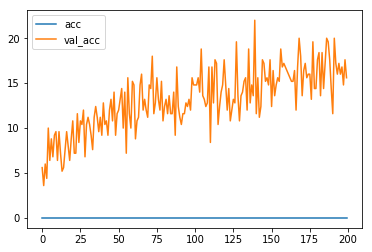

Best one-shot accuracy obtained: 22.0


In [27]:
# create directory if doesn't exist yet
try:
    os.mkdir("models")
except(FileExistsError):
    pass

loops = 200
best_acc = 0
plot_acc = PlotAccuracy()
plot_acc.on_train_begin()
for i in range(loops):
    print("=== Training loop {} ===".format(i+1))
    # train on first 80 classes
    train(siamese_net, x_train_1)
    
    # evaluate on remainng 20 classes
    test_acc = test_oneshot(siamese_net, x_test_1)
    
    # plot and save model
    plot_acc.on_epoch_end(i, {'acc': 0, 'val_acc': test_acc})
    if test_acc >= best_acc:
        print("New best one-shot accuracy, saving model ...")
        siamese_net.save(os.path.join("models", "siamese_cifar.h5"))
        best_acc = test_acc
print("Best one-shot accuracy obtained:", best_acc)

***
 One-shot learning with neural codes

* Train a CNN classifier on the first 80 classes of Cifar-100. Make sure it achieves at least 40% classification accuracy on those 80 classes (use the test set to validate this accuracy).
* Then use neural codes from one of the later hidden layers of the CNN with L2-distance to evaluate one-shot learning accuracy for the remaining 20 classes of Cifar-100 with 250 random tasks. I.e. for a given one-shot task, obtain neural codes for the test image as well as the support set. Then pick the image from the support set that is closest (in L2-distance) to the test image as your one-shot prediction.

In [28]:
idx = np.argsort(y_test, axis=None)
x_train_2 = x_train_1.reshape(-1, *input_shape)
x_test_2 = x_test[idx].reshape(n_classes, -1, *input_shape)[:80].reshape(-1, *input_shape)  # Pick first 80 classes from test set
y_train_2 = to_categorical(y_train_1.reshape(-1), y_train_1.shape[0])
y_test_2 = to_categorical(y_test[idx].reshape(n_classes, -1, 1)[:80].reshape(-1), y_train_1.shape[0])
print(x_train_2.shape)
print(y_train_2.shape)
print(x_test_2.shape)
print(y_test_2.shape)

(40000, 32, 32, 3)
(40000, 80)
(8000, 32, 32, 3)
(8000, 80)


In [29]:
convnet = Sequential()
convnet.add(Conv2D(128, (3, 3), activation='relu', input_shape=input_shape, padding="same"))
convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.5))
convnet.add(Conv2D(128, (7, 7), activation='relu'))
convnet.add(BatchNormalization())
convnet.add(Dropout(0.5))
convnet.add(Conv2D(256, (10, 10), activation='relu', padding="same"))
# convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.5))
convnet.add(Conv2D(512, (3, 3), activation='relu', padding="same"))
# convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.5))
convnet.add(Flatten())
convnet.add(BatchNormalization())
convnet.add(Dense(256, name="neural_codes", activation="relu"))
convnet.add(Dense(80, activation="softmax"))
convnet.summary()
convnet.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 128)       802944    
_________________________________________________________________
batch_normalization_7 (Batch (None, 10, 10, 128)       512       
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 10, 128)       0         
__________

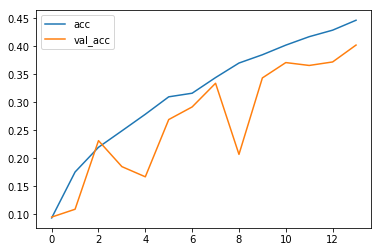

Test score: 2.362870588064194
Test accuracy: 0.402125


In [31]:

# train and evaluate
batch_size = 100
nr_epochs = 50
plot_acc = PlotAccuracy()
early_stop = EarlyStoppingByValue(monitor='val_acc', value=0.4, mode='min')
history = convnet.fit(x=x_train_2, y=y_train_2,
                      batch_size=batch_size, epochs=nr_epochs,
                      verbose=1, callbacks=[plot_acc, early_stop],
                      validation_data=(x_test_2, y_test_2))
score = convnet.evaluate(x_test_2, y_test_2, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [32]:
test_acc = test_oneshot_nc(convnet, x_test_2.reshape(n_classes, -1, *input_shape))

Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 19.6% accuracy for 20-way one-shot learning


***

**b)** Briefly motivate your CNN architecture, and discuss the difference in one-shot accuracy between the Siamese network approach and the CNN neural codes approach.

**Answer:** 

Model architecture:
- The siamese network uses identitical networks for two input "legs". 
- Each leg contains 4 convolutional layers progressively building in size (i.e. number of feature maps) with increasing depth to learn more higher level features. Learning good high level features is important with Cifar-100 dataset because it is very diverse (high variance) in terms of labels and in distribution of input pixels between classes. 
- The convolutional layers use "same" padding plus some max-pooling operations to control size of representation. This is combined with 50% dropout layers to control overfitting which can happen easily, again, due to the diversity of the dataset.
- We used batch normalization to speed up training. The distribution of each layer's inputs changes during training, as the parameters of the previous layers change(ref: https://arxiv.org/abs/1502.03167). Batch normalization also helps to address this covariance shift problem.
- At the end, we flatten the output to get flat vector, apply batch normalization to stabilize the distribution of the representation and trim it to 256 neural codes representation.
- For the comparison part, we obtain L1-distance between left and right input and apply sigmoid to obtain similarity score between 0 and 1.